## Multimodal Training Depth Marker

Predict depth markers from full images and geotemp metadata

In [1]:
# Vipin
#import os
#os.chdir("/storage/projects/BGR Soil")
!pwd

/mnt/KInsektDaten/teo


TODOs: check models dir

In [2]:
import os
import pickle

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_  # modifies the tensors in-place (vs clip_grad_norm)
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
import sys
sys.path.append('./BGR')
from bgr.soil.data.datasets import ImageTabularDataset
from bgr.soil.data.horizon_tabular_data import HorizonDataProcessor
import bgr.soil.modelling.general_models as bgr_mod
from bgr.soil.callbacks import EarlyStopping, ModelCheckpoint
from bgr.soil.transforms import VerticalStripeCrop
from bgr.soil.metrics import DepthMarkerLoss, TopKHorizonAccuracy, DepthIoULoss, depth_iou
from bgr.soil.utils import pad_tensor

### Data Loading

In [5]:
dataprocessor = HorizonDataProcessor(label_embeddings_path='./BGR/label_embeddings/all_horizons_embeddings.pickle')
df = dataprocessor.load_processed_data()

train_df, val_df, _ = dataprocessor.multi_label_stratified_shuffle_split(df)

/mnt/KInsektDaten/teo/./BGR/bgr/soil/data/horizon_tabular_data.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GrundwaStand'] = df['GrundwaStand'].str.replace('>', '').astype(float)
/mnt/KInsektDaten/teo/./BGR/bgr/soil/data/horizon_tabular_data.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ycoord'] = df['ycoord'].astype(float)
/mnt/KInsektDaten/teo/./BGR/bgr/soil/data/horizon_tabular_data.py:373: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fu

In [6]:
exploded_df = df.explode('Karbonat')
exploded_df = exploded_df.explode('Humusgehaltsklasse')  # Apply on the updated DataFrame
exploded_df = exploded_df.explode('Durchwurzelung')      # Apply on the updated DataFrame

# Used for constructing the tabular predictors in the general model
# For every tabular feature name, specify the output dimension and if it's a classification task
tabular_predictors_dict = {
    #'Soil_Type_Predictor':  {'output_dim': len(df['Bodenart'].unique()),           'classification': True},
    #'Soil_Color_Predictor': {'output_dim': len(df['Bodenfarbe'].unique()),         'classification': True},
    'Stones_Predictor':     {'output_dim': 1,                                      'classification': False},
    'Carbonate_Predictor':  {'output_dim': len(exploded_df['Karbonat'].unique()),           'classification': True},
    'Humus_Predictor':      {'output_dim': len(exploded_df['Humusgehaltsklasse'].unique()), 'classification': True},
    'Rooting_Predictor':    {'output_dim': len(exploded_df['Durchwurzelung'].unique()),     'classification': True}
}

tabular_predictors_dict

{'Stones_Predictor': {'output_dim': 1, 'classification': False},
 'Carbonate_Predictor': {'output_dim': 8, 'classification': True},
 'Humus_Predictor': {'output_dim': 8, 'classification': True},
 'Rooting_Predictor': {'output_dim': 7, 'classification': True}}

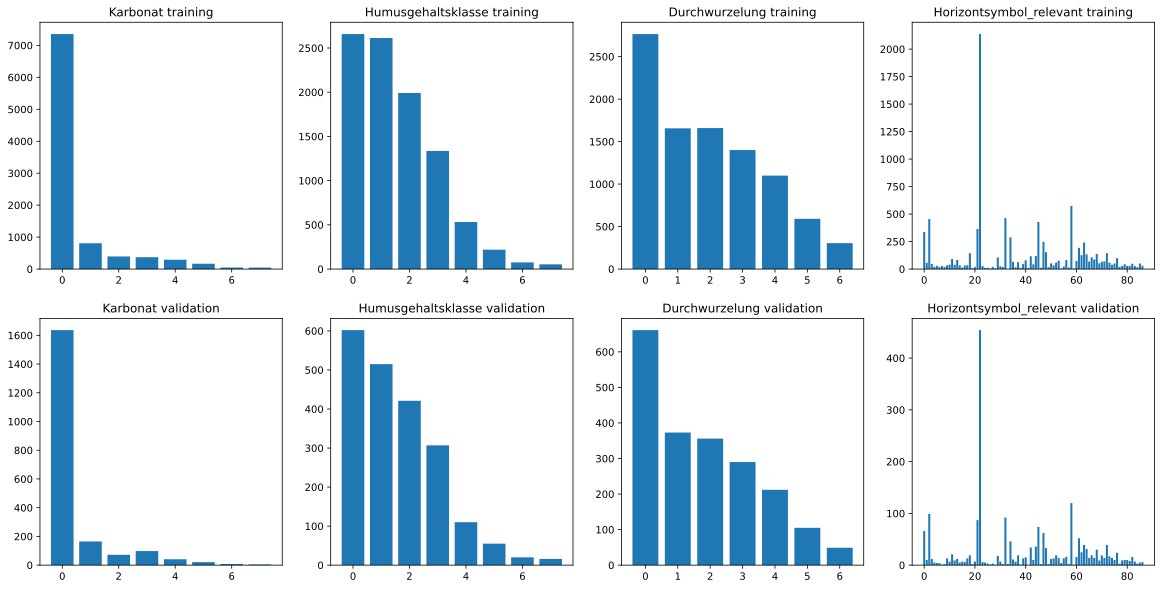

In [7]:
# If already computed, load the HCE embeddings for the labels (see Label_Graph.ipynb)
with open('./BGR/label_embeddings/all_horizons_embeddings.pickle', 'rb') as handle:
    emb_dict = pickle.load(handle)

plt.figure(figsize=(20, 10))
for i, (tab_feature, tab_predictor) in enumerate(zip(list(dataprocessor.stratified_split_targets), list(tabular_predictors_dict.keys())[1:] + ['Horizon_Predictor'])):
    if tab_predictor == 'Horizon_Predictor':
        num_cls = emb_dict['embedding'].shape[0]
    else:
        num_cls = tabular_predictors_dict[tab_predictor]['output_dim']
    for _ in range(num_cls):
        counts_train = train_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)
        counts_val   = val_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)

    plt.subplot(2, 4, i+1)
    plt.bar(list(range(num_cls)), list(counts_train.values))
    plt.title(tab_feature + ' training')
    plt.subplot(2, 4, i+5)
    plt.bar(list(range(num_cls)), list(counts_val.values))
    plt.title(tab_feature + ' validation')
plt.show()

In [8]:
# Get the lengths of the lists in the 'Untergrenze' column
list_lengths = df['Untergrenze'].apply(len)

min_length = list_lengths.min()
max_length = list_lengths.max()

print(f"Minimum number of horizons: {min_length}")
print(f"Maximum number of horizons: {max_length}")

Minimum number of horizons: 2
Maximum number of horizons: 8


In [9]:
min_length_list = df[df['Untergrenze'].apply(len) == min_length]['Untergrenze'].values[0]
max_length_list = df[df['Untergrenze'].apply(len) == max_length]['Untergrenze'].values[0]
print(f"List with minimum length: {min_length_list}")
print(f"List with maximum length: {max_length_list}")

List with minimum length: [0.32, 1.0]
List with maximum length: [0.13, 0.26, 0.4, 0.58, 0.68, 0.83, 0.98, 1.0]


In [10]:
# Define the image normalization
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
])

In [11]:
# Note: year and month should be handled differently
geotemp_categ = list(set(dataprocessor.categ_features).intersection(set(dataprocessor.geotemp_img_infos)))
# Get new number of geotemp columns
col_geotemp = [c for gt in dataprocessor.geotemp_img_infos for c in df.columns if c.startswith(gt)]

In [12]:
# Initialize model
#num_classes = len(df[target].unique()) # for one-hot encoding
#num_classes = emb_dict['embedding'].shape[1] # for HCE (the dim. of final layer in the model should match the dim of the embedded label vectors)
model = bgr_mod.HorizonSegmenter(geo_temp_input_dim=len(col_geotemp)-2,       # without counting the img path and index
                                 geo_temp_output_dim=256,
                                 max_seq_len = max_length,                    # fixed from longest list of horizons in one image from dataset
                                 stop_token=1.0,                              # End of Sequence Token at -1 meters
                                 #transformer_dim=128,
                                 #num_transformer_heads=4,
                                 #num_transformer_layers=2,
                                 rnn_hidden_dim=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

HorizonSegmenter(
  (image_encoder): PatchCNNEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [13]:
# Load pretrained model
#model.load_state_dict(torch.load('./BGR/models/lstm_depthmarker.pth'))

<All keys matched successfully>

In [15]:
# Data split
#train_df, val_df = train_test_split(df, stratify=df[target], random_state=2024)
#train_df, val_df = train_test_split(df, random_state=2024) # ToDo: not stratified...

print(f'{len(train_df)} samples for training.')
print(f'{len(val_df)} samples for validating.')

2342 samples for training.
502 samples for validating.


In [16]:
# Define the image transforms for augmentation
augment = [
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1., 3.))
    # VerticalStripeCrop(stripe_width_range=(150, 200)),
    # VerticalStripeCrop(stripe_width_range=(100, 150))
]

In [17]:
batch_size = 8
# Create Dataset object with image and tabular features
train_dataset = ImageTabularDataset(dataframe=train_df,
                                             normalize=normalize,
                                             augment=augment,
                                             image_path='file',
                                             label=None, # no label column as input; access it instead via 'index' during training
                                             feature_columns=col_geotemp[:-1]) # without 'file'

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16,
                          drop_last=True) # any better idea than drop_last? without it, tensors don't get concatenated properly

# Training parameters
lr, reg = 1e-4, 1e-2
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg)

depth_loss_mse = DepthMarkerLoss(lambda_mono=0.0, lambda_div=0.0)
depth_loss_iou = DepthIoULoss(model.stop_token)
# All the tabular classifiers get a CE loss, all regressors get MSE
soil_losses = {}
for tab_predictor in tabular_predictors_dict:
    if tabular_predictors_dict[tab_predictor]['classification']:
        soil_losses[tab_predictor] = nn.CrossEntropyLoss()
    else:
        soil_losses[tab_predictor] = nn.MSELoss()

horizon_loss = nn.CosineEmbeddingLoss() # for HCE: 1 - cos(prediction, target)
horizon_acc = TopKHorizonAccuracy(torch.tensor(emb_dict['embedding'], device=device).float(), k=1)
hor_k = 5
horizon_topk_acc = TopKHorizonAccuracy(torch.tensor(emb_dict['embedding'], device=device).float(), k=hor_k)

In [18]:
print(f"Training size original: {len(train_dataset.dataframe)}")
print(f"Training size after augmentation: {len(train_dataset)}")

Training size original: 2342
Training size after augmentation: 2342


In [16]:
# Check an augmented subset
if augment:
    aug_images = []
    for i in range(len(train_dataset)):
        image, tabular_features = train_dataset[i]
        aug_images.append(image)
        #print(f"Image {i}")
        #print(tabular_features)
        if i == 2: break

    plt.figure(figsize=(10, 8))
    for i in range(len(aug_images)):
        plt.subplot(1, 3, i+1)
        plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
        plt.axis('off')

In [19]:
val_dataset = ImageTabularDataset(dataframe=val_df,
                                           normalize=normalize,
                                           image_path='file',
                                           label=None,
                                           feature_columns=col_geotemp[:-1]) # without 'file'

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=True)

### Model Development / Training

In [18]:
### Callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.1, min_lr=lr*0.01, verbose=True)
#scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_strategy='linear', anneal_epochs=20, swa_lr=lr*0.01)
early_stopping = EarlyStopping(patience=10, min_delta=0.01, verbose=True) # looks at val_loss (see callbacks.py)
model_name = 'lstm_depthmarker'
checkpoint = ModelCheckpoint(save_path='./BGR/models/' + model_name + '.pth', monitor='avg_val_loss', mode='min', verbose=True)

/storage/projects/BGR Soil/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
epochs = 20
lr_history, train_loss_history, val_loss_history = [], [], []
train_iou_history, val_iou_history = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    model.train() # Important: reset the model in training mode at the beginning of every epoch
    train_loss_total = 0.0
    train_iou = 0.0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        images, geotemp_features = batch
        images, geotemp_features = images.to(device), geotemp_features.to(device)

        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop

        # Get corresponding true depth markers and morphological features via index column in df (the first value in every row in geotemp)
        # Note: the code accounts for duplicate indexes resulting after the augmentations in the ImageTabularDataset class (is there a better way than duplicating indexes during augmentation?)
        true_depths = []
        batch_indices = geotemp_features.cpu().numpy()[:, 0]
        for idx in batch_indices:
            true_depths.append( df.loc[df['index'] == idx, 'Untergrenze'].values[0] )

        # Turn list of depths into a padded tensor and also return mask of valid positions
        padded_true_depths = pad_tensor(true_depths,
                                        max_seq_len=model.depth_marker_predictor.max_seq_len,
                                        stop_token=model.depth_marker_predictor.stop_token,
                                        device=device)

        # Predict depth markers (as padded tensors)
        pred_depths = model(images=images, geo_temp=geotemp_features[:, 1:]) # 'index' column not used in model

        # Compute individual losses, then sum them together for backprop
        # Note: MSE is roughly between 0.01 and 0.1, hence the loss weight 10
        train_loss = 10*depth_loss_mse(pred_depths, padded_true_depths) + \
                     depth_loss_iou(pred_depths, padded_true_depths)
        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate batch losses to total loss
        train_loss_total += train_loss.item()

        # Calculate IoU
        train_iou += depth_iou(pred_depths, padded_true_depths, model.stop_token)

        train_loader_tqdm.set_postfix(loss=train_loss.item())

    # Average losses and iou at the end of the epoch
    avg_train_loss = train_loss_total / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)

    # Evaluation loop
    model.eval() # Set model in evaluation mode before running inference
    val_loss_total = 0.0
    val_iou = 0.0
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            images, geotemp_features = batch
            images, geotemp_features = images.to(device), geotemp_features.to(device)

            # Get corresponding true depth markers via index column in df (see training step above)
            true_depths = []
            batch_indices = geotemp_features.cpu().numpy()[:, 0]
            for idx in batch_indices:
                true_depths.append( df.loc[df['index'] == idx, 'Untergrenze'].values[0] )

            # Turn list of depths into a padded tensor and also return mask of valid positions
            padded_true_depths = pad_tensor(true_depths,
                                            max_seq_len=model.depth_marker_predictor.max_seq_len,
                                            stop_token=model.depth_marker_predictor.stop_token,
                                            device=device)

            # Predict depth markers (as padded tensors) and morphological features
            pred_depths = model(images=images, geo_temp=geotemp_features[:, 1:]) # 'index' column not used in model

            # Compute batch losses
            val_loss = 10*depth_loss_mse(pred_depths, padded_true_depths) + \
                       depth_loss_iou(pred_depths, padded_true_depths)

            # Add batch losses to total loss
            val_loss_total += val_loss.item()

            # Calculate IoU
            val_iou += depth_iou(pred_depths, padded_true_depths, model.stop_token)

    # Average losses and iou at the end of the epoch
    avg_val_loss = val_loss_total / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    # Save checkpoint if validation loss is at an optimum
    checkpoint(model, avg_val_loss)
    # Apply the scheduler with validation loss
    scheduler.step(avg_val_loss)
    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)

    # Log metrics
    train_loss_history.append(avg_train_loss); val_loss_history.append(avg_val_loss)
    train_iou_history.append(avg_train_iou); val_iou_history.append(avg_val_iou)

    print(f"Epoch {epoch+1}, Total Training Depth Loss: {avg_train_loss:.4f}, Training IoU: {avg_train_iou:.4f}")
    print(f"\nTotal Validation Depth Loss: {avg_val_loss:.4f}, Validation IoU: {avg_val_iou:.4f}")
    print(f"Current LR: {current_lr}")

    # Early stopping check
    early_stopping(avg_val_loss)
    if early_stopping.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/20


Model checkpoint saved at './BGR/models/lstm_depthmarker.pth' with avg_val_loss: 0.0138
Epoch 1, Total Training Depth Loss: 0.0420, Training IoU: 0.4178

Total Validation Depth Loss: 0.0138, Validation IoU: 0.4511
Current LR: 0.0001
Epoch 2/20


Model checkpoint saved at './BGR/models/lstm_depthmarker.pth' with avg_val_loss: 0.0119
Epoch 2, Total Training Depth Loss: 0.0120, Training IoU: 0.4677

Total Validation Depth Loss: 0.0119, Validation IoU: 0.4739
Current LR: 0.0001
EarlyStopping: No improvement for 1 epochs.
Epoch 3/20


Epoch 3, Total Training Depth Loss: 0.0112, Training IoU: 0.4820

Total Validation Depth Loss: 0.0124, Validation IoU: 0.4890
Current LR: 0.0001
EarlyStopping: No improvement for 2 epochs.
Epoch 4/20


Model checkpoint saved at './BGR/models/lstm_depthmarker.pth' with avg_val_loss: 0.0117
Epoch 4, Total Training Depth Loss: 0.0108, Training IoU: 0.4927

Total Validation Depth Loss: 0.0117, Validation IoU: 0.4967
Current LR: 0.0001
EarlyStopping: No improvement for 3 epochs.
Epoch 5/20


Epoch 5, Total Training Depth Loss: 0.0104, Training IoU: 0.5056

Total Validation Depth Loss: 0.0124, Validation IoU: 0.4904
Current LR: 0.0001
EarlyStopping: No improvement for 4 epochs.
Epoch 6/20


Model checkpoint saved at './BGR/models/lstm_depthmarker.pth' with avg_val_loss: 0.0114
Epoch 6, Total Training Depth Loss: 0.0098, Training IoU: 0.5160

Total Validation Depth Loss: 0.0114, Validation IoU: 0.5134
Current LR: 1e-05
EarlyStopping: No improvement for 5 epochs.
Epoch 7/20


Model checkpoint saved at './BGR/models/lstm_depthmarker.pth' with avg_val_loss: 0.0112
Epoch 7, Total Training Depth Loss: 0.0087, Training IoU: 0.5343

Total Validation Depth Loss: 0.0112, Validation IoU: 0.5184
Current LR: 1e-05
EarlyStopping: No improvement for 6 epochs.
Epoch 8/20


Epoch 8, Total Training Depth Loss: 0.0087, Training IoU: 0.5352

Total Validation Depth Loss: 0.0113, Validation IoU: 0.5183
Current LR: 1e-05
EarlyStopping: No improvement for 7 epochs.
Epoch 9/20


Model checkpoint saved at './BGR/models/lstm_depthmarker.pth' with avg_val_loss: 0.0112
Epoch 9, Total Training Depth Loss: 0.0086, Training IoU: 0.5376

Total Validation Depth Loss: 0.0112, Validation IoU: 0.5204
Current LR: 1e-05
EarlyStopping: No improvement for 8 epochs.
Epoch 10/20


Model checkpoint saved at './BGR/models/lstm_depthmarker.pth' with avg_val_loss: 0.0111
Epoch 10, Total Training Depth Loss: 0.0083, Training IoU: 0.5406

Total Validation Depth Loss: 0.0111, Validation IoU: 0.5208
Current LR: 1.0000000000000002e-06
EarlyStopping: No improvement for 9 epochs.
Epoch 11/20


Model checkpoint saved at './BGR/models/lstm_depthmarker.pth' with avg_val_loss: 0.0111
Epoch 11, Total Training Depth Loss: 0.0083, Training IoU: 0.5411

Total Validation Depth Loss: 0.0111, Validation IoU: 0.5202
Current LR: 1.0000000000000002e-06
EarlyStopping: No improvement for 10 epochs.
Early stopping at epoch 11


### Evaluation

In [20]:
# Depths-LSTM check
for true_dep, pred_dep in zip(padded_true_depths, pred_depths):
    print('True:')
    print(true_dep)
    print('Predicted:')
    print(pred_dep)
    print(' ')

True:
tensor([0.1400, 0.2300, 0.3500, 0.5400, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.0774, 0.2314, 0.4579, 0.7334, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3400, 0.5400, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.2685, 0.5561, 0.8443, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3000, 0.7400, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.1903, 0.4572, 0.7740, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.2434, 0.5166, 0.7959, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3000, 0.5400, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.2279, 0.4926, 0.7716, 1.

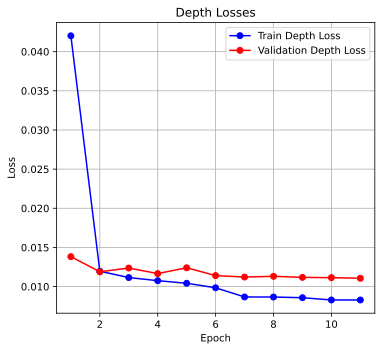

In [21]:
complete_epochs = len(train_loss_history) + 1
loss_histories = {
    'Depth': (train_loss_history, val_loss_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(loss_histories.items()):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Loss', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Loss', marker='o', color='r')
    plt.title(f'{title} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

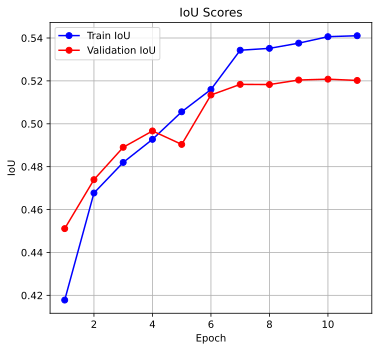

In [22]:
iou_histories = {
    'IoU': (train_iou_history, val_iou_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(iou_histories.items()):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title}', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title}', marker='o', color='r')
    plt.title(f'{title} Scores')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

In [23]:
history_data = {
    'train_loss': train_loss_history,
    'val_loss': val_loss_history,
    'train_iou': train_iou_history,
    'val_iou': val_iou_history
}

# Save the dictionary to a pickle file
with open('./BGR/figures/histories/' + model_name + '.pickle', 'wb') as f:
    pickle.dump(history_data, f)

In [24]:
# Load history dictionary
with open('./BGR/figures/histories/' + model_name + '.pickle', 'rb') as handle:
    history_data = pickle.load(handle)